In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import seaborn as sns
sns.set(style='whitegrid')
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 1500)

import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

from sklearn.linear_model import RidgeCV

In [2]:
# loading Estelle's csv to get demographic predictors
election_demographic = pd.read_csv('raw_data/train_election_demographic.csv')

In [3]:
train_df = pd.read_csv('train_test_data/train_updated2.csv')
test_df = pd.read_csv('train_test_data/testing_set.csv')

In [4]:
# I will use train_merge.columns a bit later
# to get the column names of this
train_merge=pd.concat([election_demographic.iloc[:, election_demographic.columns.get_loc('TOT_POP'):election_demographic.columns.get_loc('NA_FEMALE')+1],
                       election_demographic.iloc[:, election_demographic.columns.get_loc('At Least High School Diploma'):election_demographic.columns.get_loc('School Enrollment')+1],
                       election_demographic.loc[:, 'Poverty Estimate, All Ages'],
                       election_demographic.loc[:, 'Median Household Income'],
                       election_demographic.iloc[:, election_demographic.columns.get_loc('NUI'):election_demographic.columns.get_loc('NIC')+1],
                       election_demographic.iloc[:, election_demographic.columns.get_loc('--'):election_demographic.columns.get_loc('Wholesale')+1]], axis=1)

In [5]:
# check out the train_df
train_df.head()

,State,ST,FIPS,County,Precincts,Votes,Democrats 08 (Votes),Democrats 12 (Votes),Republicans 08 (Votes),Republicans 12 (Votes),Republicans 2016,Democrats 2016,Green 2016,Libertarians 2016,Republicans 2012,Republicans 2008,Democrats 2012,Democrats 2008,SUMLEV,YEAR,AGEGRP,TOT_POP,TOT_MALE,TOT_FEMALE,WA_MALE,WA_FEMALE,BA_MALE,BA_FEMALE,IA_MALE,IA_FEMALE,AA_MALE,AA_FEMALE,NA_MALE,NA_FEMALE,TOM_MALE,TOM_FEMALE,WAC_MALE,WAC_FEMALE,BAC_MALE,BAC_FEMALE,IAC_MALE,IAC_FEMALE,AAC_MALE,AAC_FEMALE,NAC_MALE,NAC_FEMALE,NH_MALE,NH_FEMALE,NHWA_MALE,NHWA_FEMALE,NHBA_MALE,NHBA_FEMALE,NHIA_MALE,NHIA_FEMALE,NHAA_MALE,NHAA_FEMALE,NHNA_MALE,NHNA_FEMALE,NHTOM_MALE,NHTOM_FEMALE,NHWAC_MALE,NHWAC_FEMALE,NHBAC_MALE,NHBAC_FEMALE,NHIAC_MALE,NHIAC_FEMALE,NHAAC_MALE,NHAAC_FEMALE,NHNAC_MALE,NHNAC_FEMALE,H_MALE,H_FEMALE,HWA_MALE,HWA_FEMALE,HBA_MALE,HBA_FEMALE,HIA_MALE,HIA_FEMALE,HAA_MALE,HAA_FEMALE,HNA_MALE,HNA_FEMALE,HTOM_MALE,HTOM_FEMALE,HWAC_MALE,HWAC_FEMALE,HBAC_MALE,HBAC_FEMALE,HIAC_MALE,HIAC_FEMALE,HAAC_MALE,HAAC_FEMALE,HNAC_MALE,HNAC_FEMALE,FIPS.1,At Least High School Diploma,At Least Bachelors's Degree,Graduate Degree,School Enrollment,Civilian_labor_force_2016,Employed_2016,Unemployed_2016,Unemployment_rate_2016,Postal Code,"Poverty Estimate, All Ages","Poverty Percent, All Ages","Poverty Estimate, Age 0-17","Poverty Percent, Age 0-17","Poverty Estimate, Age 5-17 in Families","Poverty Percent, Age 5-17 in Families",Median Household Income,NIPR,NUI,NIC,PCTUI,PCTIC,PCTELIG,PCTLIIC,--,Administrative,Agriculture,Construction,Educational Services,Finance,Food services,Health care,Information,Management,Manufacturing,Mining,Other,Professional Services,Real Estate,Recreation,Retail,Transportation,Utitilities,Wholesale,pres_rep_receipts,pres_rep_disburse,pres_rep_cash_on_hand,pres_dem_receipts,pres_dem_disburse,pres_dem_cash_on_hand,senate_rep_receipts,senate_rep_disburse,senate_rep_cash_on_hand,senate_dem_receipts,senate_dem_disburse,senate_dem_cash_on_hand,# of state advanced ballots cast 2012,# of state advanced ballots cast 2016,# votes 2012,# votes 2016,% of state pop 2012,% of state pop 2016,2012 Population,2016 Population,calculated approx. county adv. Ballots 2012,calculated approx. county adv. Ballots 2016,early_voting,felony_laws,id_laws,reg_laws,state population 2012,state population 2016,Democrats 12,Republicans 12,Democrats 08,Republicans 08,lag_response_dem,lag_response_rep,response_rep,response_dem,house_rep_receipts,house_rep_disburse,house_rep_cash_on_hand,house_dem_receipts,house_dem_disburse,house_dem_cash_on_hand
0,Alabama,AL,1005,Barbour County,18.0,10390.0,5697.0,5912.0,5866.0,5550.0,52.271415,46.660250,0.173244,0.895091,48.189633,50.438521,51.332812,48.985383,50,9,0,25806,13626,12180,6779,6071,6515,5858,91,60,54,58,28,13,159,120,6897,6176,6622,5929,168,107,69,78,33,18,13004,11689,6272,5665,6473,5811,40,33,54,58,16,6,149,116,6383,5766,6573,5881,111,78,69,77,21,11,622,491,507,406,42,47,51,27,0,0,12,7,10,4,514,410,49,48,57,29,0,1,12,7,1005,71.9,13.5,6.0,67.85,8436.0,7736.0,700.0,8.3,AL,6787.0,29.9,2146.0,39.6,1502.0,36.8,32884.0,17997.0,2252.0,15745.0,12.5,87.5,12.5,87.5,452.0,30.0,65.0,115.0,25.0,210.0,255.0,215.0,25.0,NaN,135.0,20.0,180.0,160.0,100.0,25.0,440.0,145.0,40.0,75.0,205.0,5271.0,0.0,0.0,0.0,0.0,5914160.0,13077935.0,9992806.0,33268.0,32369.0,442.0,0,2399,11509.0,10469.0,0.005642,0.005306,27169,25806,0.0,12.729161,2.0,1.0,3.0,2.0,4815588,4863525,51.579131,48.420869,49.269221,50.730779,1.046883,0.954467,1.348916e+06,1.204114e+06,7539913.77,6867367.47,3303589.32,1935424.42,1389839.56,964586.58
1,Alabama,AL,1113,Russell County,19.0,19136.0,10085.0,10500.0,8705.0,8278.0,48.129181,50.047032,0.355351,1.468436,43.775780,46.021676,55.526177,53.317473,50,9,0,58185,28154,30031,14667,15001,12371,13772,167,154,169,317,77,83,703,704,15281,15616,12772,14167,407,404,344,494,121,128,26541,28532,13527,13932,12084,13491,120,111,143,297,68,73,599,628,14050,14483,12424,13849,311,320,297,456,98,109,1613,1499,1140,1069,287,281,47,43,26,20,9,10,104,76,1

In [6]:
# make the transformation based on Estelle's suggestsions. 
# So what we are doing here is to fill up some NAN value
train_df['Median Household Income']=train_df['Median Household Income'].astype(float)
train_df['Poverty Estimate, All Ages']=train_df['Poverty Estimate, All Ages'].astype(float)

In [7]:
## Ivan's EDA about Unemployment Rate:
## Here I am gonig to subset certian features

ivan_df = train_df[['State', 'FIPS', 'County', 'Civilian_labor_force_2016', 'Employed_2016', 'Unemployed_2016', \
                    'Unemployment_rate_2016', 'lag_response_dem', 'lag_response_rep', \
                    'Democrats 2016', 'Republicans 2016']]

# mae a copy to get rid of the warning:
ivan_df = ivan_df.copy()

In [197]:
ivan_df.head()

,State,FIPS,County,Civilian_labor_force_2016,Employed_2016,Unemployed_2016,Unemployment_rate_2016,lag_response_dem,lag_response_rep,Democrats 2016,Republicans 2016
0,Alabama,1005,Barbour County,8436.0,7736.0,700.0,8.3,1.046883,0.954467,46.660250,52.271415
1,Alabama,1103,Morgan County,55092.0,52056.0,3036.0,5.5,0.988554,1.004416,22.436038,74.797464
2,Alabama,1069,Houston County,44735.0,42156.0,2579.0,5.8,1.007777,0.996750,25.093980,72.726624
3,Alabama,1087,Macon County,7900.0,7301.0,599.0,7.6,1.000498,0.996626,82.727481,15.935071
4,Alabama,1011,Bullock County,4844.0,4514.0,330.0,6.8,1.029620,0.914591,75.090406,24.228887


In [8]:
ivan_df.describe()

,FIPS,Civilian_labor_force_2016,Employed_2016,Unemployed_2016,Unemployment_rate_2016,lag_response_dem,lag_response_rep,Democrats 2016,Republicans 2016
count,3139.000000,3.139000e+03,3.139000e+03,3139.000000,3139.000000,3111.000000,3111.000000,3111.000000,3111.000000
mean,30392.532972,5.053195e+04,4.807176e+04,2460.191781,5.237910,0.914320,1.051450,31.679286,63.608655
std,15156.298611,1.649161e+05,1.567516e+05,8322.767768,1.889084,0.090419,0.059625,15.325975,15.619852
min,1001.000000,8.600000e+01,8.200000e+01,4.000000,1.700000,0.402420,0.739898,3.144654,4.122067
25%,18180.000000,4.956000e+03,4.653500e+03,258.000000,4.000000,0.864559,1.016407,20.445081,54.947224
50%,29177.000000,1.147700e+04,1.092200e+04,623.000000,4.900000,0.928079,1.046684,28.461992,66.715489
75%,45080.000000,3.144850e+04,2.994450e+04,1632.000000,6.100000,0.979585,1.081753,39.948068,75.056740
max,56045.000000,5.030508e+06,4.765899e+06,264609.000000,24.100000,1.403628,1.487731,92.846592,95.272727


In [9]:
ivan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3139 entries, 0 to 3138
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   State                      3139 non-null   object 
 1   FIPS                       3139 non-null   int64  
 2   County                     3139 non-null   object 
 3   Civilian_labor_force_2016  3139 non-null   float64
 4   Employed_2016              3139 non-null   float64
 5   Unemployed_2016            3139 non-null   float64
 6   Unemployment_rate_2016     3139 non-null   float64
 7   lag_response_dem           3111 non-null   float64
 8   lag_response_rep           3111 non-null   float64
 9   Democrats 2016             3111 non-null   float64
 10  Republicans 2016           3111 non-null   float64
dtypes: float64(8), int64(1), object(2)
memory usage: 269.9+ KB


In [10]:
# Check rows that have null values
has_null = ivan_df.isnull()
row_null = has_null.any(axis=1)

ivan_null_row = ivan_df[row_null]
ivan_null_row.head()

## Found that there are many Alaska are missing republican's and demorates 2016 data
## So we are going to drop them for now.

,State,FIPS,County,Civilian_labor_force_2016,Employed_2016,Unemployed_2016,Unemployment_rate_2016,lag_response_dem,lag_response_rep,Democrats 2016,Republicans 2016
67,Alaska,2130,Ketchikan Gateway Borough,7015.0,6558.0,457.0,6.5,NaN,NaN,NaN,NaN
68,Alaska,2170,Matanuska-Susitna Borough,47351.0,43455.0,3896.0,8.2,NaN,NaN,NaN,NaN
69,Alaska,2016,Aleutians West Census Area,3974.0,3842.0,132.0,3.3,NaN,NaN,NaN,NaN
70,Alaska,2195,Petersburg Borough,1449.0,1318.0,131.0,9.0,NaN,NaN,NaN,NaN
71,Alaska,2110,Juneau City and Borough,17316.0,16540.0,776.0,4.5,NaN,NaN,NaN,NaN


In [11]:
ivan_updated_df = ivan_df.dropna()
ivan_updated_df_c = ivan_updated_df.copy()

In [12]:
ivan_updated_df_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3111 entries, 0 to 3138
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   State                      3111 non-null   object 
 1   FIPS                       3111 non-null   int64  
 2   County                     3111 non-null   object 
 3   Civilian_labor_force_2016  3111 non-null   float64
 4   Employed_2016              3111 non-null   float64
 5   Unemployed_2016            3111 non-null   float64
 6   Unemployment_rate_2016     3111 non-null   float64
 7   lag_response_dem           3111 non-null   float64
 8   lag_response_rep           3111 non-null   float64
 9   Democrats 2016             3111 non-null   float64
 10  Republicans 2016           3111 non-null   float64
dtypes: float64(8), int64(1), object(2)
memory usage: 291.7+ KB


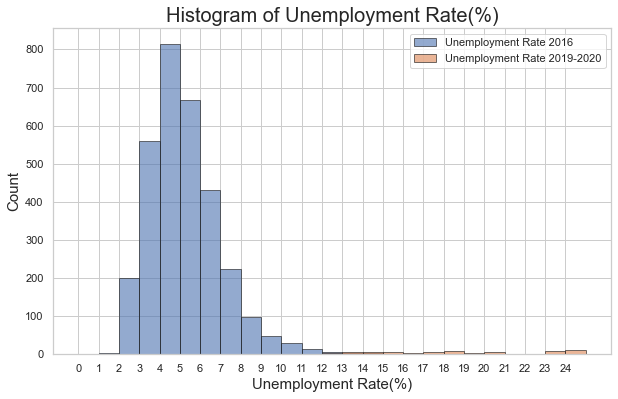

In [13]:
# First we are dealing with unemployment rate varaible
# make histogram for 'unemployment_rate_2016'
plt.figure(figsize=(10, 6))
plt.hist(ivan_updated_df_c.Unemployment_rate_2016, bins=range(26), edgecolor='k', alpha=0.6,
        label='Unemployment Rate 2016')
plt.hist(test_df.Unemployed_2019, bins=range(26), edgecolor='k', alpha=0.6, 
         label= 'Unemployment Rate 2019-2020')

plt.ylabel('Count', fontsize=15)
plt.xlabel('Unemployment Rate(%)', fontsize=15)

plt.xticks(np.arange(25))
plt.title('Histogram of Unemployment Rate(%)', fontsize=20)

plt.legend()
plt.show()

In [14]:
# Figure 11 Histogram of Unemployment Rate (%) in 2016 and 2019-2020

# It seems the median and the mode of unemployment rate are falling 
# around 4-6 percent
# When comparing between Unemployment Rate 2019-2020, first of all, they are way less people reporting.
# Second, they unemployment rate are much higher in 2019-2020

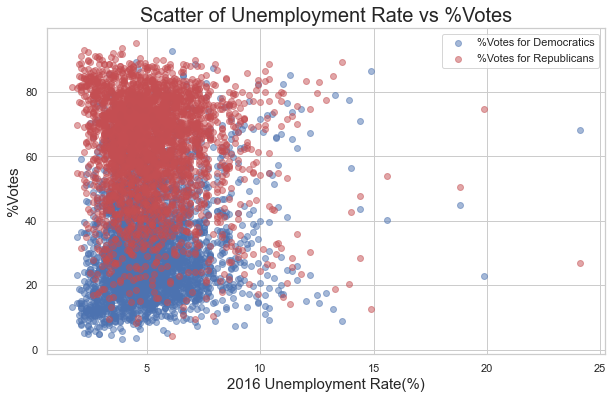

In [15]:
# make scatter plot of unemployment rate vs resposne_dem and response_rep
plt.figure(figsize=(10, 6))

plt.scatter(ivan_updated_df_c.Unemployment_rate_2016, ivan_updated_df_c['Democrats 2016'], color='b', 
            alpha=0.5, label="%Votes for Democratics")
plt.scatter(ivan_updated_df_c.Unemployment_rate_2016, ivan_updated_df_c['Republicans 2016'], color='r',
            alpha=0.5, label='%Votes for Republicans')


plt.xlabel('2016 Unemployment Rate(%)', fontsize=15)
plt.ylabel(r'%Votes', fontsize=15)
plt.title('Scatter of Unemployment Rate vs %Votes', fontsize=20)

plt.legend()

plt.show()

In [16]:
# Figure 12 Scatter Plot of Unemployment Rate (%) vs %Votes

# It seems that when unemployment rate is below 10 percentage, it is more likely to vote 
# for republicans than democrats

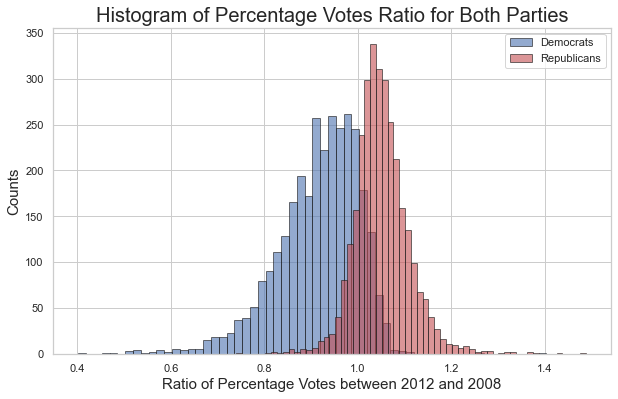

In [17]:
# Now, we are dealing with both 'lag_response_dem' and 'lag_response_rep' variables.
# Figure 13 - Histogram of Percentage Votes Ratio between 2012 and 2008 for Both Parties

plt.figure(figsize=(10,6))

plt.hist(ivan_updated_df_c.lag_response_dem, bins=60, edgecolor='k', alpha=0.6, 
        color='b', label='Democrats')
plt.hist(ivan_updated_df_c.lag_response_rep, bins=60, edgecolor='k', alpha=0.6, 
         color='r', label='Republicans')

plt.xlabel('Ratio of Percentage Votes between 2012 and 2008', fontsize=15)
plt.ylabel('Counts', fontsize=15)
plt.title('Histogram of Percentage Votes Ratio for Both Parties', fontsize=20)

plt.legend()
plt.show()

In [208]:
# This suggests that majorities of counties are shifting their voting habits 
# And they are moving to vote more for republicans
# in 2016.

In [18]:
# Here I'm adding a log-transformed response variable to avoid the right skewed.
# Here i'm constructing one Noah's variable
train_df['log_response_dem'] = np.log(train_df['response_dem'])
train_df['bal2016/popu2016'] = train_df['calculated approx. county adv. Ballots 2016'] / train_df['2016 Population']

In [19]:
## Building our model
# Initialie our predictor sets and I am training with response variables 'response_dem'
demograph_pred = list(train_merge.columns)
economic_pred = ['Unemployment_rate_2016']
financial_pred = ['house_dem_receipts', 'house_dem_disburse', 'house_dem_cash_on_hand'] # we used house instead to repre
voting_pred = ['bal2016/popu2016', 'early_voting', 'felony_laws', 'id_laws', 'reg_laws']
consistency_pred = ['lag_response_dem']

# all response variables
train_response1 = 'response_dem' # votes weighed with whole population
train_response2 = 'log_response_dem' # log transformed votes
train_response3 = 'Democrats 2016' # percentage votes for democrats

# all predictors
train_pred = demograph_pred + economic_pred + financial_pred + voting_pred + consistency_pred

# all predictors + resposne variables
train_pred_response = train_pred + [train_response1] + [train_response2] + [train_response3]

In [20]:
#train_pred in list(train_df.columns)
for pred in train_pred:
    if pred not in list(train_df.columns):
        print(pred)

# This confirms that all predictors in our selected are in the training set.

In [21]:
# Here, i'm checking if there are any null values
# So, first, I need to replace all the missing values
# of business patterns with 0

business_nan = train_df.iloc[:, train_df.columns.get_loc('--'):train_df.columns.get_loc('Wholesale')+1]
business_nan_fill = business_nan.fillna(0)
train_df.iloc[:, train_df.columns.get_loc('--'):train_df.columns.get_loc('Wholesale')+1] = business_nan_fill


In [22]:
# All the nan has been filled
business_nan_fill[business_nan_fill.isnull().any(axis=1)]

,--,Administrative,Agriculture,Construction,Educational Services,Finance,Food services,Health care,Information,Management,Manufacturing,Mining,Other,Professional Services,Real Estate,Recreation,Retail,Transportation,Utitilities,Wholesale


In [23]:
# Now I'm checking the whole train_df
has_null = train_df[train_pred_response].isnull()
null_boolean = has_null.any(axis=1)

null_rows = train_df[train_pred_response][null_boolean]

In [24]:
## Same again, a lot of them are from Alask, so we are 
## going to drop them for now. 
train_df_final = train_df[train_pred_response].dropna()

In [25]:
## First, standardize all the training data
## The scaler can be used for future testing data
scaler = StandardScaler().fit(train_df_final)
train_df_final_s = scaler.transform(train_df_final)
train_df_final_s = pd.DataFrame(train_df_final_s, columns=train_df_final.columns)

In [26]:
train_df_final_s.describe()

,TOT_POP,TOT_MALE,TOT_FEMALE,WA_MALE,WA_FEMALE,BA_MALE,BA_FEMALE,IA_MALE,IA_FEMALE,AA_MALE,AA_FEMALE,NA_MALE,NA_FEMALE,At Least High School Diploma,At Least Bachelors's Degree,Graduate Degree,School Enrollment,"Poverty Estimate, All Ages",Median Household Income,NUI,NIC,--,Administrative,Agriculture,Construction,Educational Services,Finance,Food services,Health care,Information,Management,Manufacturing,Mining,Other,Professional Services,Real Estate,Recreation,Retail,Transportation,Utitilities,Wholesale,Unemployment_rate_2016,house_dem_receipts,house_dem_disburse,house_dem_cash_on_hand,bal2016/popu2016,early_voting,felony_laws,id_laws,reg_laws,lag_response_dem,response_dem,log_response_dem,Democrats 2016
count,3.110000e+03,3.110000e+03,3.110000e+03,3.110000e+03,3.110000e+03,3.110000e+03,3.110000e+03,3.110000e+03,3.110000e+03,3.110000e+03,3.110000e+03,3.110000e+03,3.110000e+03,3.110000e+03,3.110000e+03,3.110000e+03,3.110000e+03,3.110000e+03,3.110000e+03,3.110000e+03,3.110000e+03,3.110000e+03,3.110000e+03,3.110000e+03,3.110000e+03,3.110000e+03,3.110000e+03,3.110000e+03,3.110000e+03,3.110000e+03,3.110000e+03,3.110000e+03,3.110000e+03,3.110000e+03,3.110000e+03,3.110000e+03,3.110000e+03,3.110000e+03,3.110000e+03,3.110000e+03,3.110000e+03,3.110000e+03,3.110000e+03,3.110000e+03,3.110000e+03,3.110000e+03,3.110000e+03,3.110000e+03,3.110000e+03,3.110000e+03,3.110000e+03,3.110000e+03,3.110000e+03,3.110000e+03
mean,-1.827763e-17,7.996462e-18,7.996462e-18,-4.569407e-18,4.569407e-18,9.138813e-18,2.284703e-18,-2.056233e-17,2.284703e-18,-2.284703e-18,-4.569407e-18,6.854110e-18,2.284703e-18,9.184507e-16,-1.279434e-16,8.681873e-17,-1.279434e-16,1.142352e-17,-2.421786e-16,-2.284703e-17,6.854110e-18,1.370822e-17,2.284703e-18,1.827763e-17,1.370822e-17,9.138813e-18,-1.599292e-17,4.569407e-18,1.370822e-17,1.028116e-17,-6.854110e-18,-1.256587e-17,2.741644e-17,-2.741644e-17,9.138813e-18,5.711758e-18,-3.427055e-18,-6.854110e-18,-1.142352e-17,-4.340936e-17,-4.569407e-18,-3.655525e-17,1.005269e-16,1.690680e-16,-1.188046e-16,-4.569407e-17,-7.311051e-17,-3.655525e-17,3.655525e-17,4.569407e-17,1.188046e-16,-3.198585e-17,4.843571e-16,-1.233740e-16
std,1.000161e+00,1.000161e+00,1.000161e+00,1.000161e+00,1.000161e+00,1.000161e+00,1.000161e+00,1.000161e+00,1.000161e+00,1.000161e+00,1.000161e+00,1.000161e+00,1.000161e+00,1.000161e+00,1.000161e+00,1.000161e+00,1.000161e+00,1.000161e+00,1.000161e+00,1.000161e+00,1.000161e+00,1.000161e+00,1.000161e+00,1.000161e+00,1.000161e+00,1.000161e+00,1.000161e+00,1.000161e+00,1.000161e+00,1.000161e+00,1.000161e+00,1.000161e+00,1.000161e+00,1.000161e+00,1.000161e+00,1.000161e+00,1.000161e+00,1.000161e+00,1.000161e+00,1.000161e+00,1.000161e+00,1.000161e+00,1.000161e+00,1.000161e+00,1.000161e+00,1.000161e+00,1.000161e+00,1.000161e+00,1.000161e+00,1.000161e+00,1.000161e+00,1.000161e+00,1.000161e+00,1.000161e+00
min,-3.114610e-01,-3.121556e-01,-3.107207e-01,-3.340347e-01,-3.366861e-01,-2.413553e-01,-2.265986e-01,-2.417357e-01,-2.367081e-01,-1.380453e-01,-1.370193e-01,-1.116724e-01,-1.104212e-01,-7.133301e+00,-1.767484e+00,-1.672186e+00,-7.244103e+00,-2.823136e-01,-2.133674e+00,-2.531527e-01,-3.053180e-01,-2.866532e-01,-2.933529e-01,-5.499517e-01,-3.563989e-01,-2.441082e-01,-2.930960e-01,-2.980753e-01,-2.813622e-01,-1.857610e-01,-2.428084e-01,-2.828601e-01,-2.451664e-01,-3.252549e-01,-2.318480e-01,-2.378554e-01,-1.436755e-01,-3.338051e-01,-2.841305e-01,-5.263270e-01,-2.118790e-01,-1.913195e+00,-6.877042e-01,-6.873668e-01,-6.323978e-01,-1.504407e+00,-5.418262e-01,-8.797823e-01,-1.602157e+00,-2.149667e+00,-5.661814e+00,-2.356705e-01,-3.919273e+00,-1.865349e+00
25%,-2.780697e-01,-2.778779e-01,-2.783763e-01,-2.949449e-01,-2.984743e-01,-2.385234e-01,-2.250435e-01,-2.284356e-01,-2.246001e-01,-1.369572e-01,-1.357218e-01,-1.098595e-01,-1.085740e-01,-6.223488e-01,-6.812865e-01,-6.339214e-01,-5.374061e-01,-2.490832e-01,-6.576408e-01,-2.284190e-01,-2.756366e-01,-2.608922e-01,-2.774358e-01,-4.724973e-01,-3.228321e-01,-2.366713e-01,-2.658681e-01

In [27]:
# Initialize our X train and y train
Xtrain = train_df_final_s[train_pred].values

ytrain1 = train_df_final_s['response_dem'].values
ytrain2 = train_df_final_s['log_response_dem'].values
ytrain3 = train_df_final_s['Democrats 2016'].values

# Get both shapes for both X and y
print(Xtrain.shape)
print(ytrain1.shape)
print(ytrain2.shape)
print(ytrain3.shape)

(3110, 51)
(3110,)
(3110,)
(3110,)


In [28]:
depths = list(range(1, 50))

def calc_meanstd(X_train, y_train, depths):
    train_scores = []
    cvmeans = []
    cvstds = []
    
    for depth in depths:
        dtree = DecisionTreeRegressor(max_depth=depth).fit(X_train, y_train)
        train_score = dtree.score(X_train, y_train)
        
        # append train score
        train_scores.append(train_score)
        
        # start cv
        cv = cross_val_score(estimator=dtree, X=X_train, y=y_train, 
                            scoring='r2', cv=5)
        
        # append to the means and stds
        cvmeans.append(cv.mean())
        cvstds.append(cv.std())
    
    # transform into np arrays
    cvmeans = np.array(cvmeans)
    cvstds = np.array(cvstds)
    
    return cvmeans, cvstds, train_scores

cvmeans1, cvstds1, train_score1 = calc_meanstd(Xtrain, ytrain1, depths)
cvmeans2, cvstds2, train_score2 = calc_meanstd(Xtrain, ytrain2, depths)
cvmeans3, cvstds3, train_score3 = calc_meanstd(Xtrain, ytrain3, depths)
    

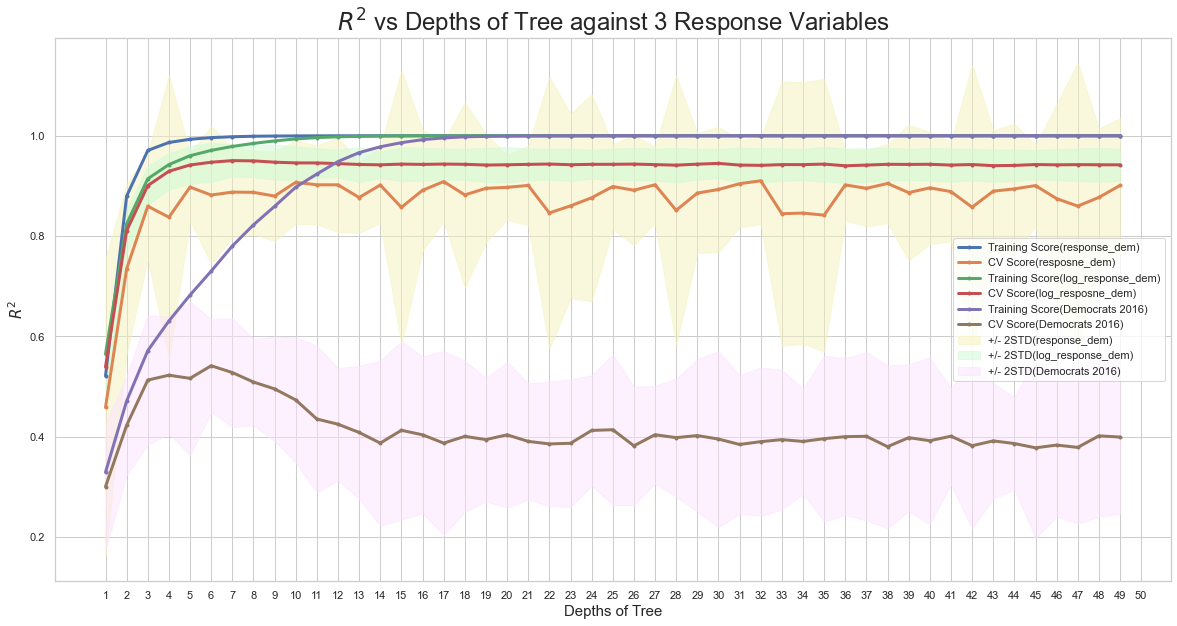

In [29]:
## make the plot
fig, ax = plt.subplots(figsize=(20, 10))

ax.plot(depths, train_score1, '.-', label='Training Score(response_dem)', lw=3)
ax.plot(depths, cvmeans1, '.-', label='CV Score(resposne_dem)', lw=3)
plt.fill_between(depths, cvmeans1+2*cvstds1, cvmeans1-2*cvstds1, color='#F5F3BB', 
                alpha=0.5, label='+/- 2STD(response_dem)')

ax.plot(depths, train_score2, '.-', label='Training Score(log_response_dem)', lw=3)
ax.plot(depths, cvmeans2, '.-', label='CV Score(log_resposne_dem)', lw=3)
plt.fill_between(depths, cvmeans2+2*cvstds2, cvmeans2-2*cvstds2, color='#CDFBD5', 
                alpha=0.5, label='+/- 2STD(log_response_dem)')

ax.plot(depths, train_score3, '.-', label='Training Score(Democrats 2016)', lw=3)
ax.plot(depths, cvmeans3, '.-', label='CV Score(Democrats 2016)', lw=3)
plt.fill_between(depths, cvmeans3+2*cvstds3, cvmeans3-2*cvstds3, color='#FDE2FF', 
                alpha=0.5, label='+/- 2STD(Democrats 2016)')

ax.set_xlabel('Depths of Tree', fontsize=15)
ax.set_ylabel('$R^{2}$', fontsize=15)
ax.set_title('$R^{2}$ vs Depths of Tree against 3 Response Variables', fontsize=24)

ax.set_xticks(np.arange(1,51))

ax.legend()
plt.show()



In [60]:
## Find the best depths for each response variables
best_depth1 = cvmeans1.argmax()+1
best_depth2 = cvmeans2.argmax()+1
best_depth3 = cvmeans3.argmax()+1


best_score1 = cvmeans1.max()
best_score2 = cvmeans2.max()
best_score3 = cvmeans3.max()

best_train_score1 = train_score1[best_depth1-1]
best_train_score2 = train_score2[best_depth2-1]
best_train_score3 = train_score3[best_depth3-1]

print("The best depth with '{0}' is {1}; has training score: {2:.4f} has a CV score: {3:.4f}".format(train_response1, best_depth1, best_train_score1, best_score1))
print("The best depth with '{0}' is {1}; has training score: {2:.4f} has a CV score: {3:.4f}".format(train_response2, best_depth2, best_train_score2, best_score2))
print("The best depth with '{0}' is {1}; has training score: {2:.4f} has a CV score: {3:.4f}".format(train_response3, best_depth3, best_train_score3, best_score3))


The best depth with 'response_dem' is 32; has training score: 1.0000 has a CV score: 0.9103
The best depth with 'log_response_dem' is 7; has training score: 0.9787 has a CV score: 0.9504
The best depth with 'Democrats 2016' is 6; has training score: 0.7302 has a CV score: 0.5415


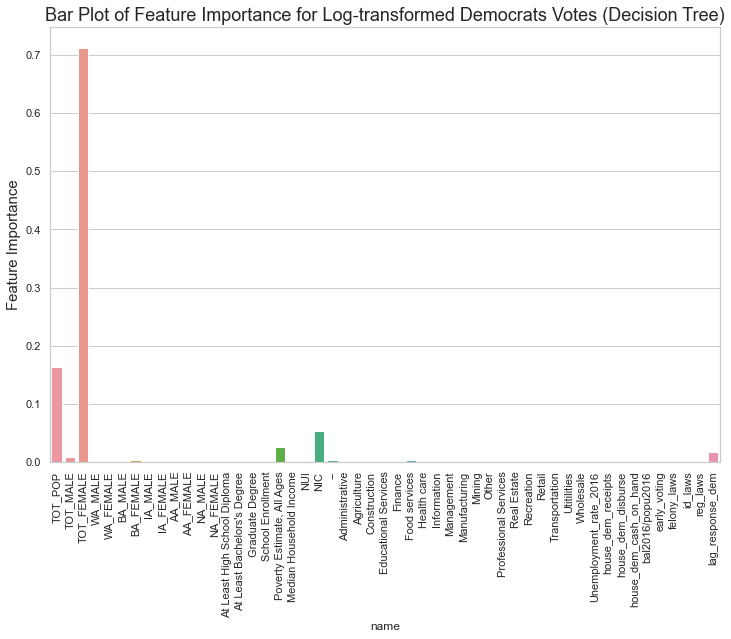

In [63]:
# It seems that dtree with depth of 7 gives the best score on 'log_response_dem' variable
# recreate a tree model with depth of 7

# recreate the X_train and y_train
Xtrain = train_df_final_s[train_pred]
ytrain_log = train_df_final_s['log_response_dem']

dtree = DecisionTreeRegressor(max_depth=best_depth2).fit(Xtrain, ytrain_log)
feature = pd.DataFrame(dtree.feature_importances_)

feature = feature.copy()
feature['name'] = Xtrain.columns

plt.figure(figsize=(12, 8))

ax = sns.barplot(x='name', y=0, data=feature)
ax.set_ylabel("Feature Importance", fontsize=15)
ax.set_title("Bar Plot of Feature Importance for Log-transformed Democrats Votes (Decision Tree)", fontsize=18)

plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()


In [62]:
# reinitialize our X train and y train
Xtrain = train_df_final_s[train_pred].values

ytrain1 = train_df_final_s['response_dem'].values
ytrain2 = train_df_final_s['log_response_dem'].values
ytrain3 = train_df_final_s['Democrats 2016'].values

# Ridge Regression with CV (from Estelle's code)

# 'response_dem' response variable
ridgecv1=RidgeCV(cv=5) # change it to 5 for consistency
ridgecv1.fit(Xtrain, ytrain1)
score1=ridgecv1.score(Xtrain, ytrain1)
cv_bes1=ridgecv1.best_score_

# 'log_response_dem' response variable
ridgecv2=RidgeCV(cv=5) 
ridgecv2.fit(Xtrain, ytrain2)
score2=ridgecv2.score(Xtrain, ytrain2)
cv_bes2=ridgecv2.best_score_

# 'democrats 2016' response variable
ridgecv3=RidgeCV(cv=5)
ridgecv3.fit(Xtrain, ytrain3)
score3=ridgecv3.score(Xtrain, ytrain3)
cv_bes3=ridgecv1.best_score_

print("With '{0}', RidgeCV has a trainging score: {1:.4f}, validation score: {2:.4f}".format(train_response1, score1, cv_bes1)) 
print("With '{0}', RidgeCV has a trainging score: {1:.4f}, validation score: {2:.4f}".format(train_response2, score3, cv_bes2)) 
print("With '{0}', RidgeCV has a trainging score: {1:.4f}, validation score: {2:.4f}".format(train_response3, score3, cv_bes3)) 


With 'response_dem', RidgeCV has a trainging score: 0.9943, validation score: 0.9836
With 'log_response_dem', RidgeCV has a trainging score: 0.6621, validation score: 0.4380
With 'Democrats 2016', RidgeCV has a trainging score: 0.6621, validation score: 0.9836


In [65]:
# so here we are training with 'response_dem'

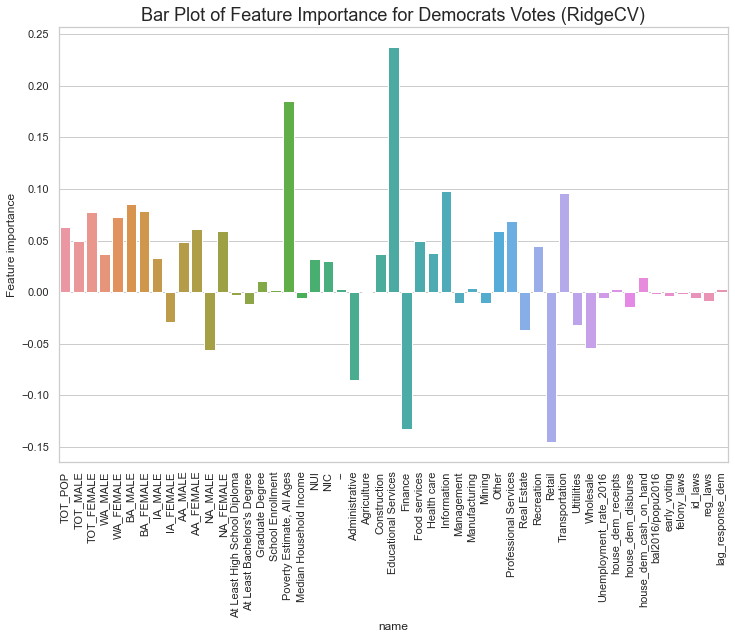

In [66]:
# recreate the X_train and y_train
Xtrain = train_df_final_s[train_pred]

ridge_feature=pd.DataFrame(ridgecv1.coef_)
ridge_feature=ridge_feature.copy()
ridge_feature['name']=Xtrain.columns

plt.figure(figsize=(12,8))

ax = sns.barplot(x="name", y=0, data=ridge_feature)
ax.set_ylabel("Feature importance")
ax.set_title("Bar Plot of Feature Importance for Democrats Votes (RidgeCV)", fontsize=18)
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()